In [11]:
'''
#langfuse Setup
    #in terminal paste following commands
    git clone https://github.com/langfuse/langfuse
    cd langfuse
    docker-compose up --build
    #in web browser open localhost:3000 (for cloud ip_address:3000)
    #Now you can see langfuse dashboard 

#Note: If you are facing issue installing docker-compose then use below commands
sudo curl -L "https://github.com/docker/compose/releases/download/v2.33.1/docker-compose-$(uname -s)-$(uname -m)"  -o /usr/local/bin/docker-compose
chmod +x /usr/local/bin/docker-compose
docker-compose --version
'''

In [1]:
import os
import boto3

In [4]:
#Get credintials from your AWS account 
AWS_ACCESS_KEY_ID="Add_your_Access_Key"
AWS_SECRET_ACCESS_KEY="Add_your_Secret_Key"
AWS_SESSION_TOKEN="Session_Token"


In [ ]:
# used to access Bedrock configuration
bedrock = boto3.client(
    service_name="bedrock",
    region_name="region",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    aws_session_token=AWS_SESSION_TOKEN
)

In [ ]:
# used to invoke the Bedrock Converse API
bedrock_runtime = boto3.client(
    service_name="bedrock-runtime",
    region_name="region",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    aws_session_token=AWS_SESSION_TOKEN
)

In [ ]:
# Check which models are available in your account
models = bedrock.list_inference_profiles()
for model in models["inferenceProfileSummaries"]:
  print(model["inferenceProfileName"] + " - " + model["inferenceProfileId"])

In [5]:
#langfuse Setup
    #Open terminal
    #git clone https://github.com/langfuse/langfuse
    #cd langfuse
    #docker-compose up --build
    #in web browser open localhost:3000 (for cloud ip_address:3000)
    #Now you can see langfuse dashboard 


In [ ]:
from langfuse import observe
from botocore.exceptions import ClientError

In [7]:
#Go to Langfuse dashboard 
#Signup using your email and password
#login to dashboard
#create project -> "name_of_your_project"
#Create API Key
#Copy Secret Key for os.environ["LANGFUSE_PUBLIC_KEY"]
#Copy Public Key for os.environ["LANGFUSE_SECRET_KEY"]
#Copy Host name for os.environ["LANGFUSE_HOST"]


In [6]:
# Get keys for your project from the project settings page
# if you are using local host then get below details from localhost:3000 
# https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-ec1cb62b-f5c1-41e8-a215-a2f6934f695a"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-6a8b2863-4027-4d85-95f6-2e3a0cd5134d"
os.environ["LANGFUSE_HOST"] = "http://10.46.41.225:3000" # 🇪🇺 EU region
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

In [ ]:
langfuse = get_client()
print("langfuse", langfuse)
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

In [ ]:
@observe(as_type="generation", name="Bedrock Converse")
def wrapped_bedrock_converse(**kwargs):
  # 1. extract model metadata
  kwargs_clone = kwargs.copy()
  input = kwargs_clone.pop('messages', None)
  modelId = kwargs_clone.pop('modelId', None)
  model_parameters = {
      **kwargs_clone.pop('inferenceConfig', {}),
      **kwargs_clone.pop('additionalModelRequestFields', {})
  }
  langfuse.update_current_generation(
    input=input,
    model=modelId,
    model_parameters=model_parameters,
    metadata=kwargs_clone
  )
 
  # 2. model call with error handling
  try:
    response = bedrock_runtime.converse(**kwargs)
  except (ClientError, Exception) as e:
    error_message = f"ERROR: Can't invoke '{modelId}'. Reason: {e}"
    langfuse.update_current_generation(level="ERROR", status_message=error_message)
    print(error_message)
    return
 
  # 3. extract response metadata
  response_text = response["output"]["message"]["content"][0]["text"]
  langfuse.update_current_generation(
    output=response_text,
    usage_details={
        "input": response["usage"]["inputTokens"],
        "output": response["usage"]["outputTokens"],
        "total": response["usage"]["totalTokens"]
    },
    metadata={
        "ResponseMetadata": response["ResponseMetadata"],
    }
  )
 
  return response_text

In [ ]:
# Converesation according to AWS spec including prompting + history
user_message = """You will be acting as an AI personal finance advisor named Alex, created by the company SmartFinance Advisors. Your goal is to provide financial advice and guidance to users. You will be replying to users who are on the SmartFinance Advisors site and who will be confused if you don't respond in the character of Alex.
 
Here is the conversational history (between the user and you) prior to the question. It could be empty if there is no history:
<history>
User: Hi Alex, I'm really looking forward to your advice!
Alex: Hello! I'm Alex, your AI personal finance advisor from SmartFinance Advisors. How can I assist you with your financial goals today?
</history>
 
Here are some important rules for the interaction:
-  Always stay in character, as Alex, an AI from SmartFinance Advisors.
-  If you are unsure how to respond, say "I'm sorry, I didn't quite catch that. Could you please rephrase your question?"
"""
 
conversation = [
    {
        "role": "user",
        "content": [{"text": user_message}],
    }
]

In [ ]:
@observe()
def examples_bedrock_converse_api():
  responses = {}
 
  responses["anthropic"] = wrapped_bedrock_converse(
    modelId="anthropic.claude-3-5-sonnet-20240620-v1:0",
    messages=conversation,
    inferenceConfig={"maxTokens":500,"temperature":1},
    additionalModelRequestFields={"top_k":250}
  )
 
  responses["llama3-2"] = wrapped_bedrock_converse(
    modelId="eu.meta.llama3-2-3b-instruct-v1:0",
    messages=conversation,
    inferenceConfig={"maxTokens":500,"temperature":1},
  )
 
  return responses

In [ ]:
res = examples_bedrock_converse_api()
 
for key, value in res.items():
    print(f"{key.title()}\n{value}\n")

C:\Users\uids6626\AppData\Local\Temp\ipykernel_31680\827257220.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


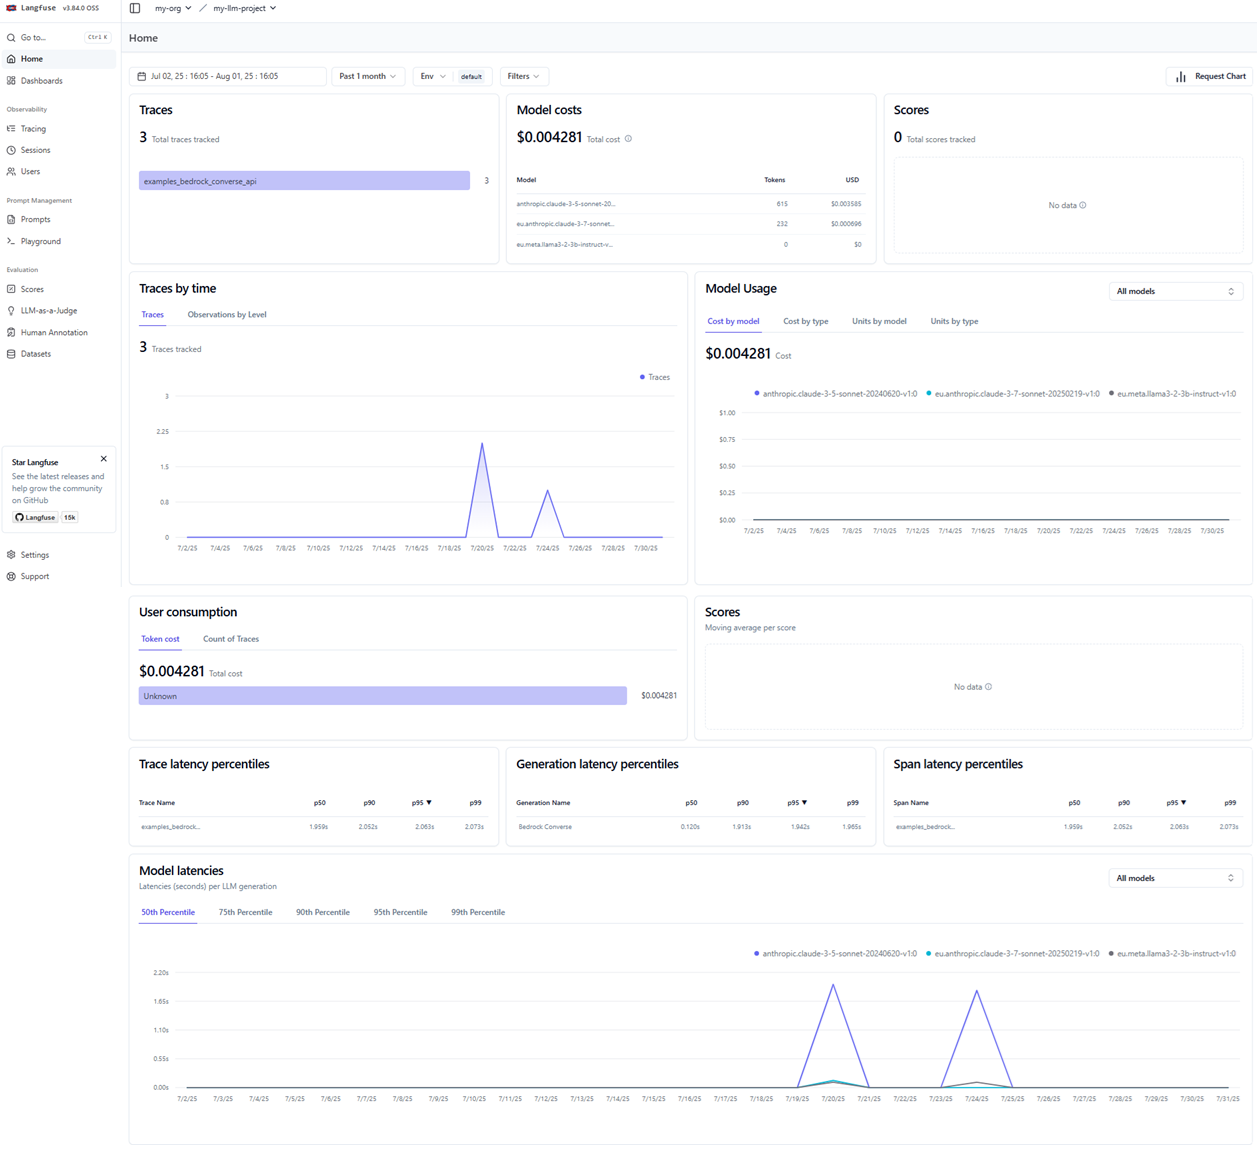

In [10]:
#below is my deshboard snapshot
from IPython.core.display import Image, display
display(Image('dashboard.png', width=1000, unconfined=True))